# Setup

## Device

In [1547]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

## Define the model

In [1548]:
import torch.nn as nn
import transformers

class ViT(nn.Module):
    def __init__(self, args):
        super().__init__()
        self.args = args
        
        # Set output_attentions=True to get attention scores
        vit_args = transformers.ViTConfig(
            hidden_size=256, 
            num_hidden_layers=6, 
            num_attention_heads=4,
            # num_attention_heads=1,
            intermediate_size=256 * 2, 
            hidden_act='gelu', 
            hidden_dropout_prob=0.1,
            attention_probs_dropout_prob=0.0, 
            initializer_range=0.02,
            layer_norm_eps=1e-12, 
            is_encoder_decoder=False, 
            image_size=args.img_size,
            patch_size=args.patch_size, 
            num_channels=args.num_channels, 
            qkv_bias=True,
            output_attentions=True,  # Enable attention outputs
            attn_implementation="eager"
        )

        self.encoder = transformers.ViTModel(vit_args)
        self.clf = nn.Linear(256, args.num_classes)

    def forward(self, x, attn_flag = False):
        # Get the output from the encoder
        outputs = self.encoder(x)
        
        # Attention scores are stored in outputs.attentions (a list of tensors)
        if attn_flag:
            attentions = outputs.attentions
        
        # Pooler output: Use the output of the CLS token
        x = outputs.pooler_output
        
        # Pass through the classifier
        x = self.clf(x)
        
        if attn_flag:
            return x, attentions
        else:
            return x
        
        


In [1549]:
!pip3 install transformers

## Dataloaders

In [1550]:
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import os
import torch


def get_loaders(args):
    train_augmentations = [transforms.Resize(args.img_size)]
    if args.padding > 0:
        train_augmentations += [transforms.RandomCrop(args.img_size, padding=args.padding)]
    if args.hflip:
        train_augmentations += [transforms.RandomHorizontalFlip()]
    train_augmentations += [transforms.ToTensor(), transforms.Normalize(mean=args.mean, std=args.std)]
    train_augmentations = transforms.Compose(train_augmentations)

    if args.dataset.lower().startswith('cifar'):
        train_dataset = datasets.__dict__[args.dataset.upper()](root=os.path.join(args.data_path, args.dataset), train=True, download=True, transform=train_augmentations)
    elif args.dataset == 'fmnist':
        train_dataset = datasets.FashionMNIST(root=os.path.join(args.data_path, args.dataset), train=True, download=True, transform=train_augmentations)
    elif args.dataset == 'svhn':
        train_dataset = datasets.SVHN(root=os.path.join(args.data_path, args.dataset), split='train', download=True, transform=train_augmentations)
    else:
        train_dataset = datasets.ImageFolder(root=os.path.join(args.data_path, args.dataset, 'train'), transform=train_augmentations)

    test_augmentations = transforms.Compose([transforms.Resize(args.img_size),
                                             transforms.ToTensor(),
                                             transforms.Normalize(mean=args.mean, std=args.std)])

    if args.dataset.lower().startswith('cifar'):
        val_dataset = datasets.__dict__[args.dataset.upper()](root=os.path.join(args.data_path, args.dataset), train=False, download=True, transform=test_augmentations)
    elif args.dataset == 'fmnist':
        val_dataset = datasets.FashionMNIST(root=os.path.join(args.data_path, args.dataset), train=False, download=True, transform=test_augmentations)
    elif args.dataset == 'svhn':
        val_dataset = datasets.SVHN(root=os.path.join(args.data_path, args.dataset), split='test', download=True, transform=test_augmentations)
    else:
        val_dataset = datasets.ImageFolder(root=os.path.join(args.data_path, args.dataset, 'val'), transform=test_augmentations)

    train_loader = torch.utils.data.DataLoader(train_dataset,
                                               batch_size=args.batch_size,
                                               shuffle=True,
                                               num_workers=args.workers,
                                               drop_last=True)

    val_loader = torch.utils.data.DataLoader(val_dataset,
                                             batch_size=args.batch_size,
                                             shuffle=False,
                                             num_workers=args.workers,
                                             drop_last=False)
    return train_loader, val_loader

## Utils

In [1551]:
import torch
import torch.nn.functional as F
import numpy as np
# from sklearn.metrics import confusion_matrix, top_k_accuracy_score
import math


def patchswap(args, x1, y1, alpha=1.0):
    m = x1.shape[0]

    new_idx = torch.randperm(m)
    x2 = x1[new_idx]
    y2 = y1[new_idx]

    x1 = x1.unfold(2, args.patch_size, args.patch_size).unfold(3, args.patch_size, args.patch_size)
    x1 = x1.reshape(-1, args.num_channels, args.num_patches, args.patch_size, args.patch_size)

    x2 = x2.unfold(2, args.patch_size, args.patch_size).unfold(3, args.patch_size, args.patch_size)
    x2 = x2.reshape(-1, args.num_channels, args.num_patches, args.patch_size, args.patch_size)

    lam = np.random.beta(alpha, alpha)

    x1_frames_count = round(lam * args.num_patches)
    lam_new = x1_frames_count / args.num_patches

    rand_probs = torch.rand(m, args.num_patches).to(device)

    if x1_frames_count > 0:
        thresh = -torch.kthvalue(-rand_probs, x1_frames_count, -1, keepdims=True)[0]
    else:
        thresh = torch.Tensor([1.1]).to(device)

    swap = rand_probs >= thresh
    swap = swap.reshape(m, 1, args.num_patches, 1, 1)
    x = x1 * swap + x2 * (~swap)

    x = x.contiguous().view(m, args.num_channels, -1, args.patch_size * args.patch_size)
    x = x.permute(0, 1, 3, 2)
    x = x.contiguous().view(m, args.num_channels * args.patch_size * args.patch_size, -1)
    x = F.fold(x, output_size=(args.img_size, args.img_size), kernel_size=args.patch_size, stride=args.patch_size)

    return x, y1, y2, lam_new


def patchswap_loss(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b) + lam * np.log(lam + 1e-6) + (1 - lam) * np.log(1 - lam + 1e-6)


def accuracy(args, target, output, k=5):
    top1 = top_k_accuracy_score(target, output, k=1, labels=range(0, args.num_classes))
    topk = top_k_accuracy_score(target, output, k=k, labels=range(0, args.num_classes))
    return top1, topk


def cmatrix(args, target, predict):
    return confusion_matrix(target, np.array(predict).argmax(1), labels=range(0, args.num_classes))


def adjust_learning_rate(optimizer, epoch, args):
    lr = args.lr
    if epoch < args.warmup:
        lr = lr / (args.warmup - epoch)
    else:
        lr *= 0.5 * (1. + math.cos(math.pi * (epoch - args.warmup) / (args.epochs - args.warmup)))

    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    print(f'Epoch: {epoch}\tlr: {lr}')

# Training

In [1552]:
import argparse
from time import time
import torch
import torch.nn as nn
import torch.optim
import torch.utils.data
import json
import os
import numpy as np



def init_parser():
    args = argparse.Namespace()
    args.data_path = './data/'
    args.dataset = 'cifar10'
    args.patch_size = 4
    args.model_path = './model/'

    args.epochs = 120
    args.warmup = 10
    args.lr = 5e-4
    args.batch_size = 128
    args.weight_decay = 3e-2
    return args

def update_args(args, config):   

    # Update arguments with values from the config file
    args.img_size = config["img_size"]
    args.hflip = config["hflip"]
    args.num_channels = config["num_channels"]
    args.num_classes = config["num_classes"]
    args.cm = config["cm"]
    args.padding = config["padding"]
    args.mean = config["mean"]
    args.std = config["std"]
    args.dataset = config['dataset']
    args.num_attention_heads=config["num_attention_heads"]
    
    
    args.epochs = config["epochs"]

    # Update other settings
    args.is_cuda = torch.cuda.is_available()
    args.num_patches = (args.img_size // args.patch_size) ** 2
    args.model_path = os.path.join(args.model_path, args.dataset)
    
    # Create model directory if it doesn't exist
    os.makedirs(args.model_path, exist_ok=True)

    # Set number of workers based on available CPU cores
    args.workers = max(os.cpu_count() - 2, 1)
    
    return args



def print_args(args):
    for k in dict(sorted(vars(args).items())).items():
        print(k)
    print()


In [1553]:
# model

In [1554]:

def train_step(args, train_loader, model, criterion, optimizer):

    model.train()
    iter_per_epoch = len(train_loader)
    actual, predict, losses = [], [], []
    for i, (x, y) in enumerate(train_loader):
        if args.is_cuda:
            x = x.to(device)
            y = y.to(device)

        x_mix, y1, y2, lam = patchswap(args, x, y)
        output = model(x_mix)
        loss = patchswap_loss(criterion, output, y1, y2, lam)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if i % 50 == 0 or i == iter_per_epoch-1:
            loss = loss.item() + lam * np.log(lam+1e-6) + (1-lam) * np.log(1-lam+1e-6)
        #   print(f'It: {i+1}/{iter_per_epoch}\tLoss: {loss:.4f}')


def test_step(args, loader, model, criterion):
    model.eval()
    actual, predict, losses = [], [], []

    with torch.no_grad():
        for (x, y) in loader:
            if args.is_cuda:
                x = x.to(device)

            output = model(x)

            losses += criterion(output, y.to(device)).tolist()
            actual += y.tolist()
            predict += output.tolist()
    acc1, acc5 = accuracy(args, actual, predict)
    avg_loss = sum(losses)/len(losses)
    cm = cmatrix(args, actual, predict)

    return acc1, acc5, cm, avg_loss


In [1555]:
''''Type-1 for traibed from scratch cifar 100 4 heads
Type -2 for trained from scratch cifar 100 1 head
Type-3 pretrained  model 
'''

def update_config(config,type):
    if(type==1):
        config["img_size"]=32
        config[ "num_classes"]=100
        config[ "dataset"]='cifar100'
        config[ "num_classes"]=100
        config["num_attention_heads"]=4
    elif(type==2):
        config["img_size"]=32
        config[ "num_classes"]=100
        config[ "dataset"]='cifar100'
        config[ "num_classes"]=100
        config["num_attention_heads"]=1
    elif(type==3):
        config["img_size"]=224
        config[ "num_classes"]=100
        config[ "dataset"]='cifar100'
        config[ "num_classes"]=100
        config["num_attention_heads"]=1

    





In [1556]:
2

2

In [1557]:
from tqdm import tqdm

In [1558]:
# # pretrained_vit
# def load_model_state_dict(model, relative_path_to_checkpoints="../Pretrained_checkpoints", filename="model_state.pth"):
#     """
#     Load the state dictionary of a pretrained model from a sibling directory.

#     Parameters:
#         model: The model object to load the state dictionary into.
#         relative_path_to_checkpoints: Relative path from the current directory to the checkpoint directory (default: '../Pretrained_checkpoints').
#         filename: The name of the checkpoint file (default: 'model_state.pth').

#     Returns:
#         None
#     """
#     # Create the full path relative to the current directory
#     file_path = os.path.join(relative_path_to_checkpoints, filename)
    
#     # Load the state dictionary
#     # Load the state dictionary
#     # print(file_path)
#     model_state_dict = torch.load(file_path, map_location='cpu', weights_only=True)
#     model.load_state_dict(model_state_dict)
#     print(f"Model loaded from {file_path}")


In [1559]:
import os
import torch

def load_model_state_dict(model, relative_path_to_checkpoints="../Pretrained_checkpoints", filename="model_state.pth"):
    """
    Load the state dictionary of a pretrained model from a sibling directory.

    Parameters:
        model: The model object to load the state dictionary into.
        relative_path_to_checkpoints: Relative path from the current directory to the checkpoint directory (default: '../Pretrained_checkpoints').
        filename: The name of the checkpoint file (default: 'model_state.pth').

    Returns:
        None
    """
    # Create the full path relative to the current directory
    file_path = os.path.join(relative_path_to_checkpoints, filename)
    
    # Load the state dictionary
    model_state_dict = torch.load(file_path, map_location='cpu')  # Removed weights_only=True
    
    # Attempt to load the state dict with strict=False to allow for mismatched keys
    missing_keys, unexpected_keys = model.load_state_dict(model_state_dict, strict=False)
    
    # Print out missing and unexpected keys for debugging
    if missing_keys:
        print(f"Missing keys in the model: {missing_keys}")
    if unexpected_keys:
        print(f"Unexpected keys in the state_dict: {unexpected_keys}")
    
    print(f"Model loaded from {file_path}")


In [1560]:
args = init_parser()
config = {
    "img_size": 32,           # CIFAR-10 image size (32x32)
    #  "img_size": 256, 
    "hflip": True,            # Horizontal flip augmentation (common for CIFAR-10)
    "num_channels": 3,        # CIFAR-10 has 3 channels (RGB)
    # "num_classes": 10,        # CIFAR-10 has 10 classes
     "num_classes": 100,        # CIFAR-10 has 10 classes
    "cm": False,  
    
    "dataset":'cifar100',  
    #  "dataset":'cifar10',      
    #     "dataset":'fmnist',
    "padding": 4,             # Typical padding used in CIFAR-10 augmentation
    "mean": [0.4914, 0.4822, 0.4465],  # Precomputed mean values for CIFAR-10 (RGB)
    "std": [0.2023, 0.1994, 0.2010]  ,  # Precomputed standard deviation for CIFAR-10 (RGB)
    "epochs"  : 120 , 
}


update_config(config,type=1)
MODEL_TYPE=1   ## MODEL TYPE 1 - FOR Trained from scratch with 32*32 size images 
               ## MODEL TYPE-2 - FOR PRETRAINED with 224*224 size images.

args = update_args(args, config)

# train_loader, val_loader = get_loaders(args)

print_args(args)


model = ViT(args)

optimizer = torch.optim.AdamW(model.parameters(), lr=args.lr, weight_decay=args.weight_decay)

criterion = nn.CrossEntropyLoss()
criterion_ = nn.CrossEntropyLoss(reduction='none')

if args.is_cuda:
    model = model.to(device)

# model.load_state

('batch_size', 128)
('cm', False)
('data_path', './data/')
('dataset', 'cifar100')
('epochs', 120)
('hflip', True)
('img_size', 32)
('is_cuda', False)
('lr', 0.0005)
('mean', [0.4914, 0.4822, 0.4465])
('model_path', './model/cifar100')
('num_attention_heads', 4)
('num_channels', 3)
('num_classes', 100)
('num_patches', 64)
('padding', 4)
('patch_size', 4)
('std', [0.2023, 0.1994, 0.201])
('warmup', 10)
('weight_decay', 0.03)
('workers', 6)



In [1561]:
# load_model_state_dict(model, relative_path_to_checkpoints="../Pretrained_checkpoints", filename="model_100_patch.pth")
load_model_state_dict(model, relative_path_to_checkpoints="../Pretrained_checkpoints", filename="cifar100_4head.pth")
model.eval()

Model loaded from ../Pretrained_checkpoints/cifar100_4head.pth


/var/folders/mt/v2_z6xpn1znd6jckkrb8kpdw0000gn/T/ipykernel_811/4053244667.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_state_dict = torch.load(file_path, map_l

ViT(
  (encoder): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 256, kernel_size=(4, 4), stride=(4, 4))
      )
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-5): 6 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=256, out_features=256, bias=True)
              (key): Linear(in_features=256, out_features=256, bias=True)
              (value): Linear(in_features=256, out_features=256, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=256, out_features=256, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=256, out_features=512, bi

In [1562]:
# !ls 

# Visualisation

In [1563]:
import os
import numpy as np

def load_data_from_directory(directory_path):
    """Load images, labels, outputs, and image IDs from the specified directory."""

    
    try:
        # Construct the full paths for each file
        ids_path = os.path.join(directory_path, 'ids.npy')
        images_path = os.path.join(directory_path, 'images.npy')
        labels_path = os.path.join(directory_path, 'labels.npy')
        outputs_path = os.path.join(directory_path, 'outputs.npy')

        # Load the numpy arrays
        img_ids = np.load(ids_path)
        images = np.load(images_path)
        labels = np.load(labels_path)
        outputs = np.load(outputs_path)

        return img_ids, images, labels, outputs

    except Exception as e:
        print(f"An error occurred: {e}")
        return None, None, None, None

# Example usage
directory_path = '../saved_images/correct'  # Adjust as needed
img_ids, images, labels, outputs = load_data_from_directory(directory_path)
preds = np.argmax(outputs,-1)


# Example to check the loaded data
if images is not None:
    print(f"Loaded {images.shape[0]} images, {labels.shape[0]} labels, {outputs.shape[0]} outputs, {img_ids.shape[0]} image IDs.")


Loaded 5 images, 5 labels, 5 outputs, 5 image IDs.


In [1564]:
preds, labels

(array([3, 8, 0, 6, 6]), array([3, 8, 0, 6, 6]))

In [1565]:
classes=['airplane',
  'automobile',
  'bird',
  'cat',
  'deer',
  'dog',
  'frog',
  'horse',
  'ship',
  'truck']

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.2933714..1.908451].


Label: 6
Label class: frog
Output: 6


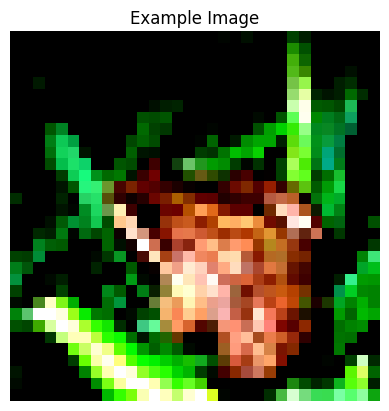

In [1566]:
import matplotlib.pyplot as plt
import numpy as np

def plot_image(image_idx, title=None):
    """
    Plot a single image using Matplotlib.

    Args:
        image (numpy.ndarray): The image to plot. It should be in the format (height, width, channels).
        title (str, optional): The title for the plot. Defaults to None.

    Returns:
        None
    """

    # Print label and output
    print(f"Label: {labels[image_idx]}")
    print(f"Label class: {classes[labels[image_idx]]}")
    print(f"Output: {preds[image_idx]}")

    image = images[image_idx]

    if image.ndim == 3 and image.shape[2] == 3:
        # Color image
        plt.imshow(image)
    elif image.ndim == 2 or (image.ndim == 3 and image.shape[2] == 1):
        # Grayscale image
        if image.ndim == 3:
            image = image.squeeze()  # Remove the channel dimension
        plt.imshow(image, cmap='gray')
    else:
        raise ValueError("Image format not recognized. Expected (H, W) or (H, W, 3) or (H, W, 1).")

    if title:
        plt.title(title)
    
    plt.axis('off')  # Hide axis
    plt.show()

# Example usage
# Assuming `images` is a numpy array of images with shape (k, H, W, C)
# and you want to plot the first image:
image_idx = 3
plot_image(image_idx, title="Example Image")


In [1567]:
from PIL import Image
import cv2
from skimage.transform import resize




def Img_Downsample(image,type=1):
   

# Assuming 'image' is the loaded image object from PIL



    if(type==1):
        resized_image = cv2.resize(image, (32, 32), interpolation=cv2.INTER_AREA)
    elif(type==2):
        resized_image = cv2.resize(image, (32, 32), interpolation=cv2.INTER_CUBIC)
    elif(type==3):
        resized_image = cv2.resize(image, (32, 32), interpolation=cv2.INTER_LINEAR)
    else:
        resized_image = resize(image, (32, 32), anti_aliasing=True)

    
    plt.imshow(resized_image)
    plt.axis('off')  # Optional: Hide the axes for a cleaner view
    plt.show()





    return resized_image

        



In [1568]:
def image_merging(image1_idx,image2_idx,method):

    # image1_idx=3
    # image2_idx=4

    image1=images[image1_idx:image1_idx+1]

    image2=images[image2_idx:image2_idx+1]

    image1 = np.squeeze(image1)
    image2 = np.squeeze(image2)
    if(method=='hstack'):
        combined_image = np.hstack((image1, image2))
        plt.imshow(combined_image)
        plt.axis('off')  # Hide axes for better visualization
        plt.show()
    else:
        combined_image = np.vstack((image1, image2))
        plt.imshow(combined_image)
        plt.axis('off')  # Hide axes for better visualization
        plt.show()

    return combined_image
# plot_image(image_idx, title="Example Image")

In [1569]:
# image2.shape

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.2933714..2.3440151].


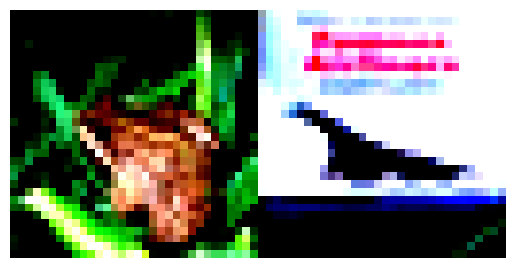

In [1570]:
combined_image=image_merging(image1_idx=3,image2_idx=2,method="hstack")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.206139..2.2464638].


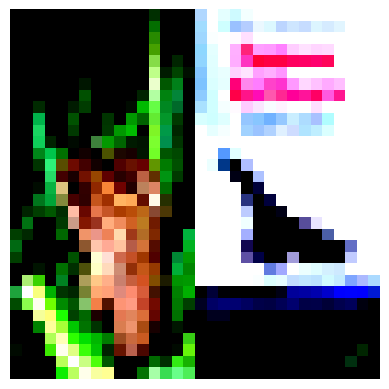

(1, 32, 32, 3)

In [1571]:
combined_image=Img_Downsample(combined_image,type=1)
combined_image.shape
combined_image=np.expand_dims(np.transpose(combined_image, (0, 1, 2)), axis=0)
combined_image.shape

In [1572]:
img=combined_image

In [1573]:
image=combined_image[0]

In [1574]:
image.shape

(32, 32, 3)

In [1575]:
import numpy as np
from PIL import Image
from torchvision import transforms
from torchvision.transforms import InterpolationMode

def scale_up(image):
    # Ensure input image is a NumPy array of shape (32, 32, 3)
    assert image.shape == (32, 32, 3), "Input image must be of shape (32, 32, 3)"

    # Define the transforms to resize and normalize the image
    pretrained_vit_transforms = transforms.Compose([
        transforms.Resize(256, interpolation=InterpolationMode.BILINEAR),  # Resize to 256x256
        transforms.CenterCrop(224),  # Crop to 224x224
        transforms.ToTensor(),  # Convert image to tensor
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize with ImageNet stats
    ])

    # Scale to [0, 255] and convert to uint8
    image_np = (image * 255).astype(np.uint8)

    # Convert the NumPy array to a PIL Image
    image_pil = Image.fromarray(image_np)

    # Apply the transformations (resize, crop, normalize)
    transformed_image = pretrained_vit_transforms(image_pil)
    
    return transformed_image


In [1576]:
# type=3
# if(type==3):
#      # Convert float array to uint8 (you may need to multiply by 255 to scale values)
#     image_np = (image * 255).astype(np.uint8)  # Scale to [0, 255] and convert to uint8

#     # Convert NumPy array to PIL Image
#     image = Image.fromarray(image_np)

#     transformed_image = pretrained_vit_transforms(image)
   

# transformed_image.shape


In [1577]:
# type(image)

In [1578]:
# from PIL import Image
# import numpy as np

# # Load the image
# image = Image.open('../saved_images/correct/hybrid.jpeg')

# # Convert image to NumPy array
# image_array = np.array(image)

# print(image_array)

In [1579]:
# image_array.shape

In [1580]:
# type(img_one)

In [1581]:
# img_one=image

In [1582]:
# raise EOFError

In [1583]:
# image = np.expand_dims(image, axis=0)
# image=image.astype(np.float32)

In [1584]:
image.shape

(32, 32, 3)

In [1585]:

if(MODEL_TYPE==1):
    image=np.expand_dims(np.transpose(image, (2, 0, 1)), axis=0)
else:

    image=scale_up(image)
    print(image.shape)
    # image=np.expand_dims(np.transpose(image, (2, 0, 1)), axis=0)
    image=np.expand_dims(image, axis=0)


image.shape

(1, 3, 32, 32)

In [1586]:
# image=np.expand_dims(np.transpose(image, (2, 0, 1)), axis=0)

In [1587]:
# image.shape

In [1588]:
# raise EOFError

In [1589]:
# img_one=image

In [1590]:
# img_one.shape

In [1591]:
img_one=image

In [1592]:
img_one.shape

(1, 3, 32, 32)

In [1593]:
# img_one = np.transpose(img_one, (0, 2, 3, 1))
img_one.shape

(1, 3, 32, 32)

In [1594]:
# img_one=combined_image
img_one.shape

(1, 3, 32, 32)

In [1595]:
# attns_list = []
# model.eval()

# with torch.inference_mode():
#     out = model(torch.tensor(img_one))
#     # print(img_one.shape)
    
    

# attns = torch.stack(attns_list)
# attns = attns.squeeze(dim=1) #remove the image dimension
# attns = attns.permute(1, 0, 2, 3)  # new shape is head x layer x q x k
# attns.shape

In [1596]:
images.shape

(5, 32, 32, 3)

In [1597]:
image_idx
images[image_idx:image_idx+1].shape


(1, 32, 32, 3)

# Getting Attention maps

In [1598]:

pass

In [1599]:
# img_one = images[image_idx:image_idx+1]

In [1600]:
# img_one.shape

In [1601]:
# img=img_one

In [1602]:
# attentions[0].shape

In [1603]:
# resize_transform = transforms.Resize((224, 224))
# upsampled_image = resize_transform(image)

In [1604]:
# type=3
# if(type==3):
#     transformed_image = pretrained_vit_transforms(image)

# transformed_image.shape


In [1605]:
import torch

# Define batch size and image dimensions
batch_size = 4
num_channels = 3  # RGB channels
image_height = 32
image_width =32

# image_height = 224
# image_width =224

# Generate a random tensor to simulate input images
# input_images = torch.randn(batch_size, num_channels, image_height, image_width)

# print(input_images.shape)
# --------------------------------------------------
# print(img_one.shape)
model.eval()
# outputs, attentions = model(input_images.to(device),True)
# out, attentions = model(torch.tensor(np.transpose(img_one, (0, 3, 1, 2))),True)
out, attentions = model(torch.tensor(img_one),True)
# attentions.shape

# Example: Access the attention scores for layer 3, head 1
layer_idx = 2  # Layer index (0-based)
head_idx = 0   # Head index (0-based)

specific_head_attention = attentions[layer_idx][:, head_idx, :, :]
print(specific_head_attention)
specific_head_attention.shape
specific_head_attention[0,1].shape



tensor([[[5.0360e-02, 4.1055e-03, 3.2148e-03,  ..., 1.7394e-02,
          9.2445e-03, 1.8685e-02],
         [5.1534e-03, 6.3557e-02, 3.9970e-02,  ..., 1.8579e-04,
          5.0523e-04, 8.3108e-02],
         [6.0597e-03, 5.9951e-02, 8.2688e-02,  ..., 1.2078e-03,
          1.9807e-03, 1.1760e-01],
         ...,
         [1.8773e-03, 2.1061e-04, 2.2925e-04,  ..., 2.8259e-01,
          1.9438e-01, 1.7021e-03],
         [3.8747e-03, 9.9472e-04, 8.7212e-04,  ..., 2.6388e-01,
          2.7416e-01, 4.6850e-03],
         [3.1801e-02, 5.3851e-02, 6.5488e-02,  ..., 3.9460e-04,
          1.2076e-03, 5.1038e-02]]], grad_fn=<SliceBackward0>)


torch.Size([65])

# Getting layerwise and headwise attention weights


In [1606]:
import torch

def get_attention_map_for_query(attentions, layer_idx, head_idx, query_patch_idx):
    """
    Extracts the attention map for a specific query patch at a given layer and head index.

    Args:
        attentions (torch.Tensor): The attention tensor of shape (num_layers, batch_size, num_heads, seq_len, seq_len).
        layer_idx (int): The index of the layer (0-based).
        head_idx (int): The index of the head (0-based).
        query_patch_idx (int): The index of the query patch (0-based).

    Returns:
        torch.Tensor: The attention weights for the specified query patch.
    """
    attns = [i.squeeze(0).detach() for i in attentions]
    attns = torch.stack(attns).permute(1, 0, 2,3)
    # print(attns.shape)
    # print(attns[head_idx][layer_idx][query_patch_idx].shape)

    return attns[head_idx][layer_idx][query_patch_idx]

    
    # return attention_for_query_patch.squeeze()

get_attention_map_for_query(attentions, layer_idx=0, head_idx=0, query_patch_idx=0)


tensor([0.0213, 0.0039, 0.0017, 0.0040, 0.0023, 0.0059, 0.0027, 0.0032, 0.0094,
        0.0021, 0.0050, 0.0067, 0.0016, 0.0013, 0.0056, 0.0079, 0.0063, 0.0070,
        0.0160, 0.0103, 0.0010, 0.0181, 0.0211, 0.0138, 0.0049, 0.0218, 0.0130,
        0.0539, 0.0035, 0.0044, 0.0123, 0.0076, 0.0054, 0.0101, 0.0265, 0.0395,
        0.0071, 0.0265, 0.0009, 0.0025, 0.0068, 0.0061, 0.0475, 0.0165, 0.0255,
        0.0263, 0.0191, 0.0393, 0.0428, 0.0071, 0.0177, 0.0418, 0.0075, 0.0066,
        0.0047, 0.0010, 0.0014, 0.0038, 0.0206, 0.0215, 0.1006, 0.0380, 0.0445,
        0.0269, 0.0086])

In [1607]:
# out, attentions = model(torch.tensor(np.transpose(img_one, (0, 3, 1, 2))),True)

In [1608]:
specific_head_attention.shape

torch.Size([1, 65, 65])

In [1609]:
# attns=specific_head_attention


In [1610]:
# len(attns)

In [1611]:
attns = [i.squeeze(0).detach() for i in attentions]


In [1612]:
attns = torch.stack(attns).permute(1, 0, 2,3)

In [1613]:
attns.shape

torch.Size([4, 6, 65, 65])

In [1614]:
import cv2

In [1615]:
def get_threshold(attn_grid,threshold,quantile_value=0.9):
    if threshold == 'mean':
        threshold = attn_grid.mean()
    elif threshold == 'median':
        threshold = attn_grid.median()
    elif threshold == 'decile':
        threshold = torch.quantile(attn_grid, 0.9)
    # elif threshold == 'otsu':
    #     # maximise interclass seperation
    #     # threshold, _ = cv2.threshold(attn_grid.cpu().numpy(), 0, 1, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    #     threshold = ski.filters.threshold_otsu(attn_row.cpu().numpy())
        # attn_grid = torch.tensor(binary_map, dtype=torch.float32)
    elif threshold == 'other':
        # Adjust quantile_value to get the top x% where x = quantile_value * 100
        threshold = torch.quantile(attn_grid, quantile_value)
    else:
        threshold = threshold # You can adjust this threshold as needed
    return threshold

In [1616]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
# Define rainbow colors from violet to red
rainbow_colors = [
    (148/255, 0/255, 211/255),  # violet
    (75/255, 0/255, 130/255),   # indigo
    (0/255, 0/255, 255/255),    # blue
    (0/255, 255/255, 0/255),    # green
    (255/255, 255/255, 0/255),  # yellow
    (255/255, 127/255, 0/255),  # orange
    (255/255, 0/255, 0/255)     # red
]
# Create the colormap
rainbow_cmap = LinearSegmentedColormap.from_list("rainbow_cmap", rainbow_colors)


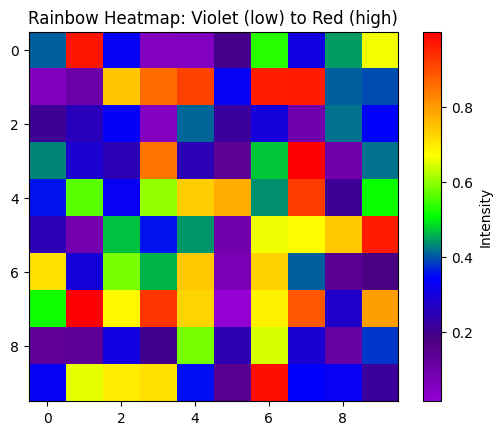

In [1617]:
# Example data for the heatmap
data = np.random.rand(10, 10)  # Random 10x10 matrix

# Plot the heatmap with the custom colormap
plt.imshow(data, cmap=rainbow_cmap, interpolation='nearest')
plt.colorbar(label="Intensity")
plt.title("Rainbow Heatmap: Violet (low) to Red (high)")
plt.show()


In [1618]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap, BoundaryNorm

def plot_attn_heatmap(attn_row, q_idx, binary=False, threshold = 0.5, figsize = (4, 4),normalize_flag = False, ax=None, overlay = False,quantile_value=0.9,model_type=1):
    # Ensure the tensor is of shape (65,)
    # assert attn_row.shape == (65,), "attn_row should have a shape of (65,)"
    
    # Remove the first element (corresponding to the [CLS] token if present)
    attn_grid = attn_row[1:]
    
    # Scaling of all values in attn_grid
    if normalize_flag:
        print("normalized")
        attn_grid = (attn_grid - attn_grid.min()) / (attn_grid.max() - attn_grid.min())
    
    # attn_grid += 
    # Apply binary thresholding if specified
    if binary:
        threshold = get_threshold(attn_grid, threshold,quantile_value)        
        attn_grid = torch.where(attn_grid >= threshold, 1.0, 0.0)
    
    # Reshape to 8x8
    if(model_type==1):
        attn_grid = attn_grid.view(8, 8)
    else:
        attn_grid=attn_grid.view(56,56)

    query_coord = ((q_idx-1) // 8, (q_idx-1) % 8)
    
    # Define custom colormap: red, yellow, and blue (only applies if not binary)
    cmap = ListedColormap(['red', 'yellow', 'blue']) if not binary else ListedColormap(['blue', 'red'])
    
    # Define boundaries for the colormap (only applies if not binary)
    bounds = [0, 0.33, 0.66, 1.0] if not binary else [0, threshold, 1.0]
    
    # Define normalization between 0 and 1 using boundaries
    norm = BoundaryNorm(bounds, cmap.N)

    # Plot the heatmap
    # plt.figure(figsize=figsize)
    ax_flag = True

    # if ax is None:
    #     plt.figure(figsize=figsize)
    #     ax_flag = False
    #     ax = plt.gca()  # Get the current axis if not provided
    #     # print("rescaled")

    if overlay and img is not None:
        # Remove the batch dimension
        # img = np.transpose(img, (1, 2, 0))  # Convert to HxWxC format
        attn_grid = attn_grid.cpu().numpy()
        target_size = img.shape[1:3]
        upsampled_attn_grid = cv2.resize(attn_grid, target_size, interpolation=cv2.INTER_NEAREST)
        mask = np.expand_dims(upsampled_attn_grid, axis=-1)  # Shape: (64, 64, 1)
        masked_img = img.squeeze(0) * mask  # Shape: (64, 64, 3)
        target_size = (attn_grid.shape[0], attn_grid.shape[1])

        masked_img = np.clip(masked_img, a_min=0, a_max=1)

        ax.imshow(masked_img)
    else:
        # sns.heatmap(attn_grid.cpu().numpy(), annot=False, cmap=cmap, norm=norm, cbar=not(ax_flag), ax=ax, linewidths=0.5, linecolor='black')
        # sns.heatmap(attn_grid.cpu().numpy(), annot=False, cmap='jet', cbar=not(ax_flag), ax=ax, linewidths=0.5, linecolor='black')
        # Upsample the attention matrix to the desired size (e.g., 100x100 as in your image)
    #    attention_matrix = np.random.rand(14, 14)  # Replace this with your actual attention matrix
    #    input_image = np.random.rand(32, 32, 3)  # Replace this with your actual image

        # Upsample the attention matrix to the desired size (e.g., 32x32)
        upsampled_attention = cv2.resize(attn_grid.cpu().numpy(), (32, 32), interpolation=cv2.INTER_LINEAR)

        # Create a figure with two subplots (1 row, 2 columns)
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))

        # Plot the upsampled attention heatmap in the first subplot
        axes[0].imshow(upsampled_attention, cmap='jet', interpolation='nearest')
        axes[0].set_title("Upsampled Attention Heatmap")
        axes[0].set_xlabel("X-axis")
        axes[0].set_ylabel("Y-axis")
        fig.colorbar(plt.cm.ScalarMappable(cmap='jet'), ax=axes[0], label="Attention Weights")

        # Plot the input image (or another visualization) in the second subplot
        axes[1].set_title("Input Image")
        axes[1].set_xlabel("X-axis")
        axes[1].set_ylabel("Y-axis")
        axes[1].imshow(img[0])

        # Show the plots
        plt.tight_layout()
        plt.show()
        
    # # Placing a black dot at the query position
    # x = query_coord[1] + 0.5
    # y  = query_coord[0] + 0.5
    # x *= 4
    # y *= 4
    
    # ax.scatter(x,y , color='black', s=100, edgecolor='white', zorder=2)
    
    # # Set title only if not using an existing axis
    # if ax_flag is False:
    #     plt.title("Attention Heatmap")
    #     plt.show()
    # return threshold

In [1619]:
# img.shape

In [1620]:
# img=img_one

In [1621]:
img.shape
# type(img)

(1, 32, 32, 3)

In [1622]:
# img=np.transpose(img_one,(0,2,3,1))


In [1623]:
# attn_row.shape

In [1624]:
for i in range(65):
    print(f'{i:02}',end=" ")
    if(i%8==0):
        print()

00 
01 02 03 04 05 06 07 08 
09 10 11 12 13 14 15 16 
17 18 19 20 21 22 23 24 
25 26 27 28 29 30 31 32 
33 34 35 36 37 38 39 40 
41 42 43 44 45 46 47 48 
49 50 51 52 53 54 55 56 
57 58 59 60 61 62 63 64 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.206139..2.2464638].


MODEL TYPE ==  1
0
5
normalized


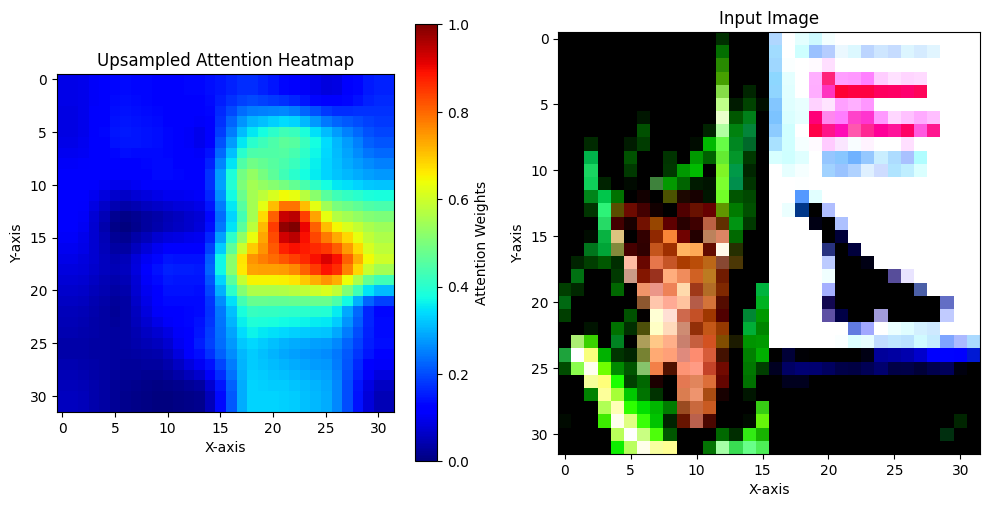

In [1625]:
# Example usage
# attn_row = torch.rand(65)  # Example attention row
print("MODEL TYPE == ",MODEL_TYPE)
# print(attns.shape)
head_idx=0
print(head_idx)
#frog
# q_idx=np.random.randint(0,65)
q_idx=5
print(q_idx)
layer_idx=5
attn_row = attns[head_idx][layer_idx][q_idx]
# attn_row = attns[layer_idx][head_idx][q_idx]
# plot_attn_heatmap(attn_row,q_idx, binary=True, threshold='mean')
# plot_attn_heatmap(attn_row,q_idx, binary=True, threshold='median')
# plot_attn_heatmap(attn_row,q_idx, binary=True, threshold='decile')
threshold = plot_attn_heatmap(attn_row,q_idx, binary=False, threshold='other', figsize = (4,4), normalize_flag=True,overlay=False,quantile_value=0.9,model_type=MODEL_TYPE)
# threshold = plot_attn_heatmap(attn_row,q_idx, binary=True, threshold='otsu', figsize = (4,4), normalize_flag=False)

In [1626]:
np.argmax(attns[head_idx][layer_idx].cpu().numpy())

np.int64(2564)

In [1627]:
from tqdm import tqdm

In [1628]:
get_threshold(attns[head_idx][layer_idx], 'otsu')

'otsu'

In [1629]:
# def plot_all_heatmaps_for_head(attns, head_idx, layer_idx, binary=False, threshold='otsu', figsize=(16, 16),overlay = True,quantile_value=0.9):
#     # Create a figure with an 8x8 grid of subplots
#     fig, axs = plt.subplots(8, 8, figsize=figsize)
#     fig.suptitle(f"Attention Heatmaps for Head {head_idx}, Layer {layer_idx}", fontsize=16)

#     # Loop over all q_idxs from 1 to 64
#     for q_idx in tqdm(range(1, 65), 'Processing query patches'):
#         attn_row = attns[head_idx][layer_idx][q_idx]
        
#         # Get the subplot position
#         ax = axs[(q_idx-1) // 8, (q_idx-1) % 8]
        
        
#         # Call the modified plot_attn_heatmap function with the provided axis
#         plot_attn_heatmap(attn_row, q_idx, binary=binary, threshold=threshold, figsize=(4, 4), ax=ax,overlay = overlay,quantile_value=quantile_value)
        
#         # Remove axis labels for a cleaner look
#         ax.set_xticks([])
#         ax.set_yticks([])
#         ax.set_title(f'Query {q_idx}')
    
#     plt.tight_layout()
#     plt.subplots_adjust(top=0.92)  # Adjust the top to make room for the title
#     plt.show()


In [1630]:
def plot_all_heatmaps_for_head(attns, head_idx, layer_idx, binary=False, threshold='otsu', figsize=(16, 16),overlay = True,quantile_value=0.9,size=32):
    # Create a figure with an 8x8 grid of subplots
    n=8
    if(size==224):
        n=16


    fig, axs = plt.subplots(n, n, figsize=figsize)
    fig.suptitle(f"Attention Heatmaps for Head {head_idx}, Layer {layer_idx}", fontsize=16)

    # Loop over all q_idxs from 1 to 64
    for q_idx in tqdm(range(1, n*n+1), 'Processing query patches'):
        attn_row = attns[head_idx][layer_idx][q_idx]
        
        # Get the subplot position
        ax = axs[(q_idx-1) // n, (q_idx-1) % n]
        
        
        # Call the modified plot_attn_heatmap function with the provided axis
        plot_attn_heatmap(attn_row, q_idx, binary=binary, threshold=threshold, figsize=(4, 4), ax=ax,overlay = overlay,quantile_value=quantile_value)
        
        # Remove axis labels for a cleaner look
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f'Query {q_idx}')
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)  # Adjust the top to make room for the title
    plt.show()


In [1631]:
## tk yajat

In [1632]:

# Example usage:
head_idx = 3
layer_idx = 5

'''Choose one of below threhold methods :'''
# threshold_method = 0.5
# threshold_method = 'mean'
# threshold_method = 'median'
# threshold_method = 'decile' #top 10% attnetion
# threshold_method = 'otsu' #maximises seperation in chosen and not chosen classes
threshold_method = 'other'

# High attention regions are transparent and low attnetion regions are black

threshold = get_threshold(attns[head_idx][layer_idx], threshold_method,quantile_value=0.9)
print(f'Threshold is {threshold*100:.2f}%')
print()
# plot_all_heatmaps_for_head(attns, head_idx=head_idx, layer_idx=layer_idx, binary=True, threshold='other',overlay = True,quantile_value=0.9)

Threshold is 2.42%



In [1633]:
out=out.detach()
# classes[out.argmax()]

In [1634]:

var=nn.Softmax(dim=1)

var(out).sum()

tensor(1.0000)

In [1635]:
out[0].shape

torch.Size([100])

In [1636]:
classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

# Bar chart for classes probability


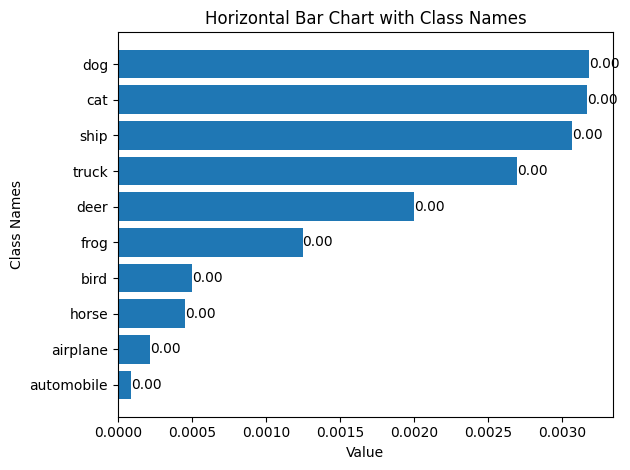

In [1637]:
import matplotlib.pyplot as plt

var=nn.Softmax(dim=1)

val = var(out)[0]

# Combine val and titlenames into a list of tuples

combined = list(zip(val, classes))

# Sort by value in descending order
sorted_combined = sorted(combined, key=lambda x: x[0], reverse=False)

# Unzip the sorted tuples back into val and titlenames
val_sorted, titlenames_sorted = zip(*sorted_combined)

# Plotting the horizontal bar chart
indices = range(len(val_sorted))
plt.barh(indices, val_sorted)
# Annotate bars with the values
for i, (value, name) in enumerate(zip(val_sorted, titlenames_sorted)):
    plt.text(value, i, f'{value:.2f}', va='center', ha='left', color='black')
# Set class names as y-axis labels
plt.yticks(indices, titlenames_sorted)

# Set labels and title
plt.ylabel('Class Names')
plt.xlabel('Value')
plt.title('Horizontal Bar Chart with Class Names')

# Show the plot
plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()

In [1638]:
import torch.nn as nn
from torchvision.datasets import CIFAR100, CIFAR10
import matplotlib.pyplot as plt

def bar_char(model_name="CIFAR_10", out=None):
    var = nn.Softmax(dim=1)
    val = var(out)[0]

    # Define classes for CIFAR-100 and CIFAR-10
    if model_name == "CIFAR_100":
        classes = [
            "apple", "aquarium_fish", "baby", "bear", "beaver", "bed", "bee", "beetle", "bicycle",
            "bottle", "bowl", "boy", "bridge", "bus", "butterfly", "camel", "can", "castle", 
            "caterpillar", "cattle", "chair", "chimpanzee", "clock", "cloud", "cockroach", "couch", 
            "crab", "crocodile", "cup", "dinosaur", "dolphin", "elephant", "flatfish", "forest", 
            "fox", "girl", "hamster", "house", "kangaroo", "keyboard", "lamp", "lawn_mower", 
            "leopard", "lion", "lizard", "lobster", "man", "maple_tree", "motorcycle", "mountain", 
            "mouse", "mushroom", "oak_tree", "orange", "orchid", "otter", "palm_tree", "pear", 
            "pickup_truck", "pine_tree", "plain", "plate", "poppy", "porcupine", "possum", "rabbit", 
            "raccoon", "ray", "road", "rocket", "rose", "sea", "seal", "shark", "shrew", "skunk", 
            "skyscraper", "snail", "snake", "spider", "squirrel", "streetcar", "sunflower", 
            "sweet_pepper", "table", "tank", "telephone", "television", "tiger", "tractor", 
            "train", "trout", "tulip", "turtle", "wardrobe", "whale", "willow_tree", "wolf", 
            "woman", "worm"
        ]
    elif model_name == "CIFAR_10":
        classes = [
            "airplane", "automobile", "bird", "cat", "deer", 
            "dog", "frog", "horse", "ship", "truck"
        ]

    # Combine val and classes into a list of tuples
    combined = list(zip(val, classes))

    # Sort by value in descending order and take top 10
    sorted_combined = sorted(combined, key=lambda x: x[0], reverse=True)[:10]

    # Unzip the sorted tuples back into val and classes
    val_sorted, classes_sorted = zip(*sorted_combined)

    # Plotting the horizontal bar chart
    indices = range(len(val_sorted))
    plt.barh(indices, val_sorted, color='skyblue')
    
    # Annotate bars with the values
    for i, (value, name) in enumerate(zip(val_sorted, classes_sorted)):
        plt.text(value, i, f'{value:.2f}', va='center', ha='left', color='black')
    
    # Set class names as y-axis labels
    plt.yticks(indices, classes_sorted)

    # Set labels and title
    plt.ylabel('Class Names')
    plt.xlabel('Probability')
    plt.title(f'Top 10 Classes by Probability ({model_name})')

    # Show the plot
    plt.tight_layout()  # Adjust layout to prevent overlapping
    plt.show()


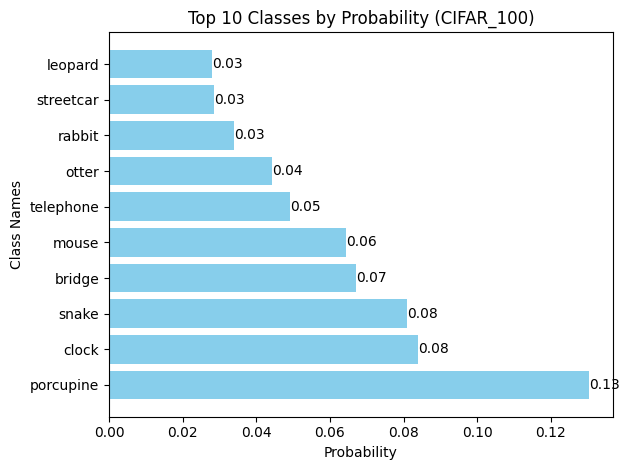

In [1639]:
bar_char(model_name="CIFAR_100",out=out)

In [1640]:
raise EOFError

EOFError: 